# Goals

1. Create Metrics DF with all errorterms from all models
    - Structure: Index = Modelname + Category, Columns = Error Metric + Horizon, Values=Metrics
    
    
2. Create Value DF with all forecasts from all models 
    - Structure: Index = Date, Columns = Modelname, Values=Forecasts 

## Setup

In [1]:
# library
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from itertools import combinations
# Get custom utils functions
import sys
sys.path.append('/Users/ludwigbaunach/Documents/Studium/PhD/Alaiko/Paper_1_Project/Main/src')

from utils.data_split import ml_data_date_split
from utils.model_utils import rmse as RMSE
from utils.evaluation_of_df_ts import create_error_dataframes

In [2]:
#data 
L_3 = pd.read_pickle("../data/processed/L_3_test.pkl")

# time series
ts_results = pd.read_pickle("../data/modelling_results/ts_results_all.pickle")

lgbm_results = pd.read_pickle("../data/modelling_results/lgbm_results.pickle")
lgbm_results_s = pd.read_pickle("../data/modelling_results/lgbm_results_selected_f.pickle")
lgbm_params = pd.read_pickle("../data/modelling_results/lgbm_params.pickle")
lgbm_importance = pd.read_pickle("../data/modelling_results/lgbm_importance.pickle")

# xgb
xgb_results = pd.read_pickle("../data/modelling_results/xgb_results.pickle")
xgb_params = pd.read_pickle("../data/modelling_results/xgb_params.pickle")
xgb_importance = pd.read_pickle("../data/modelling_results/xgb_importance.pickle")

# LSTM
lstm_results = pd.read_pickle("../data/modelling_results/lstm_results.pickle")
# nhits

nhits_results = pd.read_pickle("../data/modelling_results/nhits_results.pickle")

## Explore Data

In [3]:
lgbm_results.keys()
#lgbm_results

dict_keys(['L_3_Time_Momentum_Lag', 'L_3_Time_Momentum_Lag_Weather', 'L_3_Time_Momentum_Lag_Holiday', 'L_3_Time_Momentum_Lag_Weather_Holiday', 'L_4_Time_Momentum_Lag', 'L_4_Time_Momentum_Lag_Weather', 'L_4_Time_Momentum_Lag_Holiday', 'L_4_Time_Momentum_Lag_Weather_Holiday', 'L_6_Time_Momentum_Lag', 'L_6_Time_Momentum_Lag_Weather', 'L_6_Time_Momentum_Lag_Holiday', 'L_6_Time_Momentum_Lag_Weather_Holiday'])

In [4]:
ts_results.keys()
#ts_results

dict_keys(['L_3', 'L_6', 'L_4'])

In [5]:
lstm_results.keys()
lstm_results["L_6"]["backtest"]

,date,actual,pred,level,group
0,2022-10-13,8006,10820.825195,L_6,empty
1,2022-10-14,7604,11557.055664,L_6,empty
2,2022-10-15,7096,12103.677734,L_6,empty
3,2022-10-16,11710,13234.144531,L_6,empty
4,2022-10-17,6224,13105.624023,L_6,empty
5,2022-10-18,8281,11622.914062,L_6,empty
6,2022-10-19,6462,11961.964844,L_6,empty
7,2022-10-20,6647,9912.923828,L_6,empty
8,2022-10-21,6137,8902.305664,L_6,empty
9,2022-10-22,5842,8527.286133,L_6,empty


In [6]:
nhits_results.keys()
nhits_results["L_6"]["backtest"]

,date,actual,pred,level,group
0,2022-10-13,8006,9311.574726,L_6,empty
1,2022-10-14,7604,9331.197466,L_6,empty
2,2022-10-15,7096,9488.074874,L_6,empty
3,2022-10-16,11710,13856.748700,L_6,empty
4,2022-10-17,6224,9160.525485,L_6,empty
5,2022-10-18,8281,9449.739733,L_6,empty
6,2022-10-19,6462,10001.355017,L_6,empty
7,2022-10-20,6647,11193.336964,L_6,empty
8,2022-10-21,6137,10029.454123,L_6,empty
9,2022-10-22,5842,9061.146574,L_6,empty


## Individual Metrics

### ts_results

In [7]:
# example
ts_model_names = ts_results["L_3"]["pred"].columns[0:5]
ts_model_names

Index(['sarima', 'sarimax', 'ets', 'naive_drift', 'naive_seasonal'], dtype='object')

In [8]:
def calculate_rmse_mape(true_values, predicted_values):
    
    rmse_score = np.sqrt(mse(true_values, predicted_values))
    mape_score = mape(true_values, predicted_values)
    
    return rmse_score, mape_score

In [9]:
def create_error_df_ts(ts_results, lgbm_results):
    data = []
    index = []
    # Loop through categories
    for category_name, _ in ts_results.items():
        # Get model names
        ts_model_names = ts_results[category_name]["pred"].columns[0:5]
        
        for model_name in ts_model_names:
            # Access backtest and prediction data frame for the current level and category
            ts_backtest = ts_results[category_name]['backtest'].reset_index().groupby(["index"]).sum()
            ts_pred = ts_results[category_name]['pred'].reset_index().groupby(["index"]).sum()

            # Access actual values for backtest and prediction
            back_actual = lgbm_results["L_3_Time_Momentum_Lag"]["backtest"].groupby(["date"]).sum().actual
            pred_actual = lgbm_results["L_3_Time_Momentum_Lag"]["pred"].groupby(["date"]).sum().actual

            # Calculate RMSE and MAPE for backtest
            rmse_backtest, mape_backtest = calculate_rmse_mape(back_actual, ts_backtest[model_name])

            # Calculate RMSE and MAPE for forecast
            rmse_pred, mape_pred = calculate_rmse_mape(pred_actual, ts_pred[model_name])

            data.append([rmse_backtest, rmse_pred, mape_backtest, mape_pred])
            index.append(f"{category_name}_{model_name}")

    # Create column names
    columns = [f"val_rmse", f"pred_rmse", f"val_mape", f"pred_mape"]

    # Create the DataFrame
    df = pd.DataFrame(data, columns=columns, index=index)

    return df


In [10]:
ts_error = create_error_df_ts(ts_results, lgbm_results)

In [11]:
ts_error.sort_values("pred_rmse")

,val_rmse,pred_rmse,val_mape,pred_mape
L_4_sarimax,7555.009429,7327.508836,0.281617,0.362788
L_3_sarimax,7666.985667,7854.585471,0.287877,0.338795
L_4_sarima,11577.278722,10678.717559,0.323027,0.761114
L_6_naive_drift,9493.736196,11955.655117,0.248244,0.889731
L_4_naive_drift,9519.682117,11969.309758,0.250140,0.891030
L_3_naive_drift,9473.160300,12004.825941,0.247694,0.894405
L_3_sarima,11003.044794,14226.124467,0.291902,1.094977
L_6_sarimax,9169.691298,14856.189889,0.256728,1.177577
L_4_ets,9107.892054,19046.430546,0.222686,1.496345
L_3_ets,9272.905215,20276.732410,0.224615,1.588463


### lgbm_resuts

In [12]:
# params
#params_df = pd.DataFrame.from_dict(lgb_params, orient="index")
# save as exel
#params_df.to_excel("../data/modelling_results/lgbm_params.xlsx")

In [13]:
def create_error_df_tree(tree_results):
    # Initialize an empty list to store the results
    metrics_data = []

    # Iterate over the dataframes and categories

    for category_name, _ in tree_results.items():
        # Access backtest data frame for the current level and category
        backtest = tree_results[f"{category_name}"]['backtest'].groupby("date").sum()
        # Access prediction data frame for the current level and category
        pred = tree_results[f"{category_name}"]['pred'].groupby("date").sum()

        # Calculate RMSE
        val_rmse = np.sqrt(mse(backtest.actual, backtest.pred))
        pred_rmse = np.sqrt(mse(pred.actual, pred.pred))

        # Calculate MAPE
        val_mape = mape(backtest.actual, backtest.pred)
        pred_mape = mape(pred.actual, pred.pred)

        # Calculate MAE
        val_mae = mae(backtest.actual, backtest.pred)
        pred_mae = mae(pred.actual, pred.pred)

        # Append the results to the metrics_data list
        metrics_data.append({
            'category': category_name,
            'val_rmse': val_rmse,
            'pred_rmse': pred_rmse,
            'val_mape': val_mape,
            'pred_mape': pred_mape,
            #'val_mae': val_mae,
            #'pred_mae': pred_mae
        })
        
        lgbm_metrics = pd.DataFrame(metrics_data)
        
    return lgbm_metrics

In [14]:
# lgbm errors
lgbm_error = create_error_df_tree(lgbm_results) #.sort_values("val_rmse")
lgbm_error.sort_values("pred_rmse")

,category,val_rmse,pred_rmse,val_mape,pred_mape
4,L_4_Time_Momentum_Lag,8301.268185,4401.765889,0.200772,0.237552
2,L_3_Time_Momentum_Lag_Holiday,10032.866567,7626.565336,0.279702,0.253505
5,L_4_Time_Momentum_Lag_Weather,10314.852364,7646.154119,0.225923,0.321437
7,L_4_Time_Momentum_Lag_Weather_Holiday,7697.331885,8002.676359,0.199149,0.327482
6,L_4_Time_Momentum_Lag_Holiday,8146.471352,8343.388112,0.199984,0.312912
1,L_3_Time_Momentum_Lag_Weather,10843.976479,8502.614225,0.262772,0.272955
10,L_6_Time_Momentum_Lag_Holiday,9249.462882,8919.522308,0.240340,0.270996
0,L_3_Time_Momentum_Lag,10641.076749,9330.781444,0.308178,0.299318
3,L_3_Time_Momentum_Lag_Weather_Holiday,10431.529688,9885.510403,0.287669,0.312776
11,L_6_Time_Momentum_Lag_Weather_Holiday,9958.153274,10313.204341,0.242113,0.364408


In [15]:
# xgb error
xgb_error = create_error_df_tree(xgb_results) 
xgb_error.sort_values("pred_rmse")

,category,val_rmse,pred_rmse,val_mape,pred_mape
4,L_4_Time_Momentum_Lag,9782.241109,7881.903222,0.229808,0.381243
9,L_6_Time_Momentum_Lag_Weather,10438.875014,8228.016519,0.248375,0.258548
10,L_6_Time_Momentum_Lag_Holiday,7885.523999,8232.782463,0.232827,0.353391
0,L_3_Time_Momentum_Lag,9583.706688,8376.870117,0.318166,0.318580
11,L_6_Time_Momentum_Lag_Weather_Holiday,8822.962397,8911.333067,0.229195,0.364747
6,L_4_Time_Momentum_Lag_Holiday,8436.203921,9104.808736,0.326960,0.358869
2,L_3_Time_Momentum_Lag_Holiday,9143.887201,9316.504883,0.323553,0.303557
7,L_4_Time_Momentum_Lag_Weather_Holiday,8844.110079,9692.908381,0.350543,0.335607
8,L_6_Time_Momentum_Lag,10294.676551,9871.550009,0.225166,0.331666
3,L_3_Time_Momentum_Lag_Weather_Holiday,9642.227107,10109.708984,0.276614,0.469792


In [16]:
# save to excel 
#df_metrics.to_excel("../data/modelling_results/lgbm_metrics.xlsx")

In [17]:
#lstm_results["L_6"]["backtest"]

### Deep Learning Errors

In [18]:
def create_error_df_dl(dl_results, lgbm_results, model_name):
    
    data = []
    index = []
    # Loop through categories
    for category_name, _ in dl_results.items():

        # Access backtest and prediction data frame for the current level and category
        dl_backtest = dl_results[category_name]['backtest'].groupby(["date"]).sum().pred
        dl_pred = dl_results[category_name]['pred'].groupby(["date"]).sum().pred

        # Access actual values for backtest and prediction
        back_actual = lgbm_results["L_3_Time_Momentum_Lag"]["backtest"].groupby(["date"]).sum().actual
        pred_actual = lgbm_results["L_3_Time_Momentum_Lag"]["pred"].groupby(["date"]).sum().actual
        
        # Calculate RMSE and MAPE for backtest
        rmse_backtest, mape_backtest = calculate_rmse_mape(back_actual, dl_backtest)

        # Calculate RMSE and MAPE for forecast
        rmse_pred, mape_pred = calculate_rmse_mape(pred_actual, dl_pred)

        data.append([rmse_backtest, rmse_pred, mape_backtest, mape_pred])
        index.append(f"{category_name}_{model_name}")

    # Create column names
    columns = [f"val_rmse", f"pred_rmse", f"val_mape", f"pred_mape"]

    # Create the DataFrame
    df = pd.DataFrame(data, columns=columns, index=index)

    return df

In [19]:
lstm_error = create_error_df_dl(lstm_results, lgbm_results, "lstm")

In [20]:
nhits_error = create_error_df_dl(nhits_results, lgbm_results, "nhits")

In [21]:
nhits_error

,val_rmse,pred_rmse,val_mape,pred_mape
L_3_nhits,12285.125177,10702.372070,0.424768,0.773480
L_4_nhits,11084.816805,9745.934399,0.345429,0.529010
L_6_nhits,12554.980332,7404.363172,0.380553,0.378205


## Ensemble  Metrics

Method:

- Select best model per level: L 6,5,4,3,2,
- select SARIMAX ARIMA and ES

- make combinations

### Custom functions

In [22]:
def back_pred_df(ts_results, lgbm_results, xgb_results, lstm_results, nhits_results):
    
    # Lists to hold 'pred' series
    backtest_list = []
    pred_list = []
    
    # ts
    for key in ts_results.keys():
        for column in ts_model_names:
            backtest_series = ts_results[key]['backtest'].reset_index().groupby(["index"]).sum()[column]
            pred_series  = ts_results[key]['pred'].reset_index().groupby(["index"]).sum()[column]

            # Rename the series to the current key and column
            backtest_series.name = key + '_' + column
            pred_series.name = key + '_' + column

            # Add the series to the list
            backtest_list.append(backtest_series)
            pred_list.append(pred_series)

    # lgbm
    for key in lgbm_results.keys():

        backtest_series = lgbm_results[key]['backtest'].groupby(["date"]).sum().pred
        pred_series  = lgbm_results[key]["pred"].groupby(["date"]).sum().pred


        # Rename the series to the current key
        backtest_series.name = key + "_lgbm"
        pred_series.name = key + "_lgbm"

        # Add the series to the list
        backtest_list.append(backtest_series)
        pred_list.append(pred_series)

    # xgb
    for key in xgb_results.keys():

        backtest_series = xgb_results[key]['backtest'].groupby(["date"]).sum().pred
        pred_series  = xgb_results[key]["pred"].groupby(["date"]).sum().pred


        # Rename the series to the current key
        backtest_series.name = key + "_xgb"
        pred_series.name = key + "_xgb"

        # Add the series to the list
        backtest_list.append(backtest_series)
        pred_list.append(pred_series)

    # lstm 

    for key in lstm_results.keys():

        backtest_series = lstm_results[key]['backtest'].groupby(["date"]).sum().pred
        pred_series  = lstm_results[key]["pred"].groupby(["date"]).sum().pred


        # Rename the series to the current key
        backtest_series.name = key + "_lstm"
        pred_series.name = key + "_lstm"

        # Add the series to the list
        backtest_list.append(backtest_series)
        pred_list.append(pred_series)
        
    # nhits
    for key in lstm_results.keys():

        backtest_series = nhits_results[key]['backtest'].groupby(["date"]).sum().pred
        pred_series  = nhits_results[key]["pred"].groupby(["date"]).sum().pred


        # Rename the series to the current key
        backtest_series.name = key + "_nhits"
        pred_series.name = key + "_nhits"

        # Add the series to the list
        backtest_list.append(backtest_series)
        pred_list.append(pred_series)

        
    # Concatenate all series into one dataframe
    backtest_df = pd.concat(backtest_list, axis=1)
    pred_df = pd.concat(pred_list, axis=1)

    # attach actuals 
    # Access actual values for backtest and prediction
    backtest_df["actual"] = lgbm_results["L_3_Time_Momentum_Lag"]["backtest"].groupby(["date"]).sum().actual
    pred_df["actual"] = lgbm_results["L_3_Time_Momentum_Lag"]["pred"].groupby(["date"]).sum().actual
    
    # Set index names
    backtest_df.index.name = 'date'
    pred_df.index.name = 'date'
    
    return backtest_df, pred_df

In [23]:
def create_ensemble(backtest_df, pred_df, list_of_selected_models):
    # Lists to hold 'pred' series
    backtest_list = []
    pred_list = []

    # create list of combinations
    model_pairs = list(combinations(list_of_selected_models, 2))

    for pair in model_pairs:
        # create ensembeles 
        backtest_ensemble = (backtest_df[pair[0]] + backtest_df[pair[1]]) / 2
        pred_ensemble = (pred_df[pair[0]] + pred_df[pair[1]]) / 2

        # Rename the series to the current key
        backtest_ensemble.name = pair[0] + "_" + pair[1]
        pred_ensemble.name = pair[0] + "_" + pair[1]

        # Add the series to the list
        backtest_list.append(backtest_ensemble)
        pred_list.append(pred_ensemble)

    back_ens_df = pd.concat(backtest_list, axis=1)
    pred_ens_df = pd.concat(pred_list, axis=1)
    
    # Set index names
    back_ens_df.index.name = 'date'
    pred_ens_df.index.name = 'date'

    return back_ens_df, pred_ens_df



In [24]:
def ensemble_metrics(backtest_df, pred_df):
    
    # Initialize an empty list to store the results
    metrics_data = []

    # Iterate over the dataframes and categories

    for category_name in backtest_df.columns:
        # Access backtest data frame for the current level and category
        backtest = backtest_df[category_name]
        # Access prediction data frame for the current level and category
        pred = pred_df[category_name]

        # Calculate RMSE
        val_rmse = np.sqrt(mse(backtest_df.actual, backtest))
        pred_rmse = np.sqrt(mse(pred_df.actual, pred))

        # Calculate MAPE
        val_mape = mape(backtest_df.actual, backtest)
        pred_mape = mape(pred_df.actual, pred)

        # Calculate MAE
        val_mae = mae(backtest_df.actual, backtest)
        pred_mae = mae(pred_df.actual, pred)

        # Append the results to the metrics_data list
        metrics_data.append({
            'category': category_name,
            'val_rmse': val_rmse,
            'pred_rmse': pred_rmse,
            'val_mape': val_mape,
            'pred_mape': pred_mape,
            #'val_mae': val_mae,
            #'pred_mae': pred_mae
        })
        
        ensemble_metrics = pd.DataFrame(metrics_data)
        
    return ensemble_metrics

In [25]:
def ensemble_stats(backtest_df, pred_df):
    # Initialize lists to store the values
    column_names = []
    means = []
    standard_deviations = []

    # Calculate mean and standard deviation for each column
    for i in backtest_df.columns:
        mean = backtest_df[i].mean()
        standard_deviation = backtest_df[i].std()

        # Append the results to the lists
        column_names.append(i)
        means.append(mean)
        standard_deviations.append(standard_deviation)

    # Create new DataFrame
    stats_df = pd.DataFrame({
        'Column Name': column_names,
        'Mean': means,
        'Standard Deviation': standard_deviations
    })
    
    return stats_df

In [26]:
# Run Functions and get individual metrics (without ensembles)
back_df, pred_df = back_pred_df(ts_results, lgbm_results, xgb_results, lstm_results, nhits_results)
ind_metrics_df = ensemble_metrics(back_df, pred_df).sort_values("val_mape")

In [27]:
# Get nest Models to create ensembles (to limit compexity)
list_of_selected_models = list(ind_metrics_df[1:11].category)
list_of_selected_models.append("L_4_sarimax")

# Create ensemble and save as df
back_ens_df, pred_ens_df = create_ensemble(back_df, pred_df, list_of_selected_models)

# Backtest and prediction values 
full_back_df = back_df.merge(back_ens_df,  left_index=True, right_index=True, how="left")
full_pred_df = pred_df.merge(pred_ens_df,  left_index=True, right_index=True, how="left")

# esemble metrics
ensemble_metrics_df = ensemble_metrics(full_back_df, full_pred_df).sort_values("pred_rmse")
# test
#ensemble_metrics_df.head(50)

In [28]:
ensemble_metrics_df.head(20)

,category,val_rmse,pred_rmse,val_mape,pred_mape
45,actual,0.000000,0.000000,0.000000,0.000000
19,L_4_Time_Momentum_Lag_lgbm,8301.268185,4401.765889,0.200772,0.237552
71,L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_L...,9218.124770,5362.719006,0.206955,0.230589
72,L_4_Time_Momentum_Lag_lgbm_L_4_sarimax,7279.193773,5473.924425,0.212069,0.280790
47,L_4_Time_Momentum_Lag_Weather_Holiday_lgbm_L_4...,7960.137406,5538.363670,0.194700,0.229806
56,L_4_Time_Momentum_Lag_Holiday_lgbm_L_4_Time_Mo...,8187.847226,5593.277554,0.196491,0.219964
70,L_4_Time_Momentum_Lag_lgbm_L_6_Time_Momentum_L...,9079.432434,6550.002196,0.196894,0.267390
67,L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_L...,8098.345543,6565.319495,0.198205,0.375788
65,L_4_Time_Momentum_Lag_lgbm_L_6_Time_Momentum_L...,8676.293974,6626.070258,0.194734,0.247726
100,L_4_Time_Momentum_Lag_Weather_lgbm_L_4_sarimax,7906.129262,7186.064888,0.209792,0.318903


<AxesSubplot:xlabel='index'>

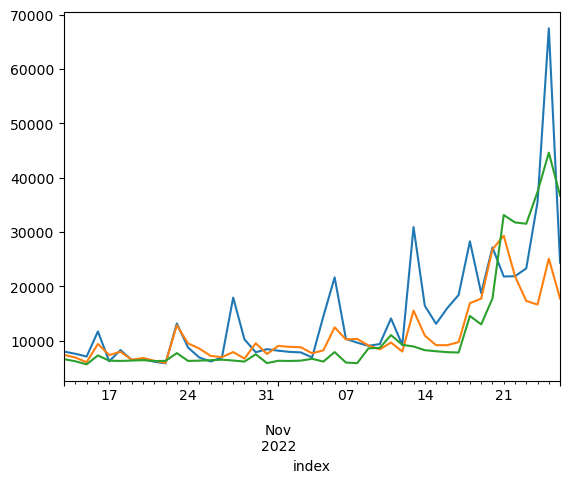

In [29]:
lgbm_results["L_4_Time_Momentum_Lag"]["backtest"].groupby("date").sum().actual.plot()
lgbm_results["L_4_Time_Momentum_Lag"]["backtest"].groupby("date").sum().pred.plot()
ts_results["L_4"]["backtest"].reset_index().groupby("index").sum().sarimax.plot()
#full_back_df.L_4_Time_Momentum_Lag_lgbm_L_4_sarimax.plot()

In [30]:
list_of_selected_models.append("L_4_sarimax")

In [31]:
len(full_back_df.columns)

101

## SAVE

In [32]:
import pickle

#with open('../data/modelling_results/ens_back_results.pickle', 'wb') as handle:
#    pickle.dump(full_back_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('../data/modelling_results/ens_pred_results.pickle', 'wb') as handle:
#    pickle.dump(full_pred_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# save to excel 
#ensemble_metrics_df.to_excel("../data/modelling_results/ensemble_metrics.xlsx")
#ind_metrics_df.to_excel("../data/modelling_results/ind_metrics.xlsx")

In [33]:
len(pd.read_pickle("../data/modelling_results/ens_back_results.pickle").columns)

101

In [34]:
len(pd.read_pickle("../data/modelling_results/ens_back_results_v2.pickle").columns)

101

# Significance

In [35]:
from scipy.stats import ttest_rel, shapiro
from scipy.stats import wilcoxon

# Assuming your DataFrame is called 'df' and has columns 'actual', 'backtest', 'prediction'
df = pd.DataFrame(metrics_data)

test = df[df["category"] == "L_5_Time_Momentum_Lag"]

stat_backtest, p_backtest = shapiro(df['val_mae'])
stat_prediction, p_prediction = shapiro(df['pred_mae'])

alpha = 0.05  # Choose your significance level

if p_backtest < alpha or p_prediction < alpha:
    print("At least one of the MAE distributions is not normal. Consider using a non-parametric test.")
else:
    # Perform paired t-test
    t_stat, p_value = ttest_rel(df['mae_backtest'], df['mae_prediction'])

    if p_value < alpha:
        print("There is a significant difference between the two models (p-value: {:.5f})".format(p_value))
    else:
        print("There is no significant difference between the two models (p-value: {:.5f})".format(p_value))



NameError: name 'metrics_data' is not defined

In [ ]:

alpha1 = 0.05  # Set a significance level (e.g., 0.05)
alpha2 = 0.01  # Set a significance level (e.g., 0.01)

significance_results = []

for category_name, _ in lgb_params.items():
    # Access backtest data frame for the current level and category
    backtest_lgb = lgbm_tr[f"{category_name}"]['backtest'].groupby("date").sum()
    backtest_arima = ts_backtest.ARIMA

    # Access prediction data frame for the current level and category
    pred_lgb = lgbm_tr[f"{category_name}"]['pred'].groupby("date").sum()
    pred_arima = ts_forecast.ARIMA

    # Perform the Wilcoxon Signed-Rank Test for backtest errors
    stat_backtest, p_value_backtest = wilcoxon(backtest_lgb.actual - backtest_lgb.pred, backtest_lgb.actual - backtest_arima)

    # Perform the Wilcoxon Signed-Rank Test for prediction errors
    stat_pred, p_value_pred = wilcoxon(pred_lgb.actual - pred_lgb.pred, backtest_lgb.actual - pred_arima)

    significance_backtest = 0
    if p_value_backtest < alpha1:
        significance_backtest = 1
    if p_value_backtest < alpha2:
        significance_backtest = 2

    significance_pred = 0
    if p_value_pred < alpha1:
        significance_pred = 1
    if p_value_pred < alpha2:
        significance_pred = 2

    significance_results.append([category_name, significance_backtest, significance_pred])

# Create a DataFrame with the results
significance_df = pd.DataFrame(significance_results, columns=['Category', 'Backtest Significance', 'Prediction Significance'])

# save to excel 
#significance_df.to_excel("../data/modelling_results/lgbm_significance.xlsx")


# Feature Importance

In [3]:
pd.read_pickle("../data/processed/L_4_test.pkl").columns

Index(['date', 'new_customer_id_0', 'new_customer_id_1', 'new_customer_id_2',
       'new_customer_id_3', 'new_customer_id_4', 'new_customer_id_5',
       'quantity', 'tm_w_end', 'tm_dy_sin', 'tm_dy_cos', 'tm_dm_sin',
       'tm_dm_cos', 'tm_wy_sin', 'tm_wy_cos', 'tm_my_sin', 'tm_my_cos',
       'tm_wm_sin', 'tm_wm_cos', 'tm_dw_sin', 'tm_dw_cos', 'q_roll_mean_9d',
       'q_roll_std_9d', 'q_roll_mean_14d', 'q_roll_std_14d', 'q_lag_9d',
       'q_lag_14d', 'q_lag_28d', 'q_lag_365d', 'q_mean_lag_9_14_28',
       'precipitation_height', 'sunshine_duration', 'temperature_air_mean_200',
       'sunshine_duration_h', 'suns_classes', 'temp_classes', 'rain_classes',
       'is_holiday', 'is_event', 'xmas_1_week', 'xmas_2_week',
       'after_xmas_week', 'event_Black_Friday', 'event_Cyber_Monday',
       'event_Thanksgiving', 'event_Valentines_Day',
       'holiday_Christi_Himmelfahrt', 'holiday_Erster_Mai',
       'holiday_Erster_Weihnachtstag', 'holiday_Karfreitag', 'holiday_Neujahr',
       

In [37]:
# test drop
['tm_y_1',
 'tm_wm_cos',
 'event_Thanksgiving',
 'holiday_Zweiter_Weihnachtstag',
 'holiday_Ostermontag',
 'holiday_Neujahr',
 'holiday_Reformationstag',
 'holiday_Karfreitag',
 'event_Valentines_Day',
 'holiday_Pfingstmontag',
 'holiday_Erster_Mai',
 'holiday_Erster_Weihnachtstag',
 'holiday_Tag_der_Deutschen_Einheit',
 'holiday_Christi_Himmelfahrt',
 'tm_y_2']

['tm_y_1',
 'tm_wm_cos',
 'event_Thanksgiving',
 'holiday_Zweiter_Weihnachtstag',
 'holiday_Ostermontag',
 'holiday_Neujahr',
 'holiday_Reformationstag',
 'holiday_Karfreitag',
 'event_Valentines_Day',
 'holiday_Pfingstmontag',
 'holiday_Erster_Mai',
 'holiday_Erster_Weihnachtstag',
 'holiday_Tag_der_Deutschen_Einheit',
 'holiday_Christi_Himmelfahrt',
 'tm_y_2']

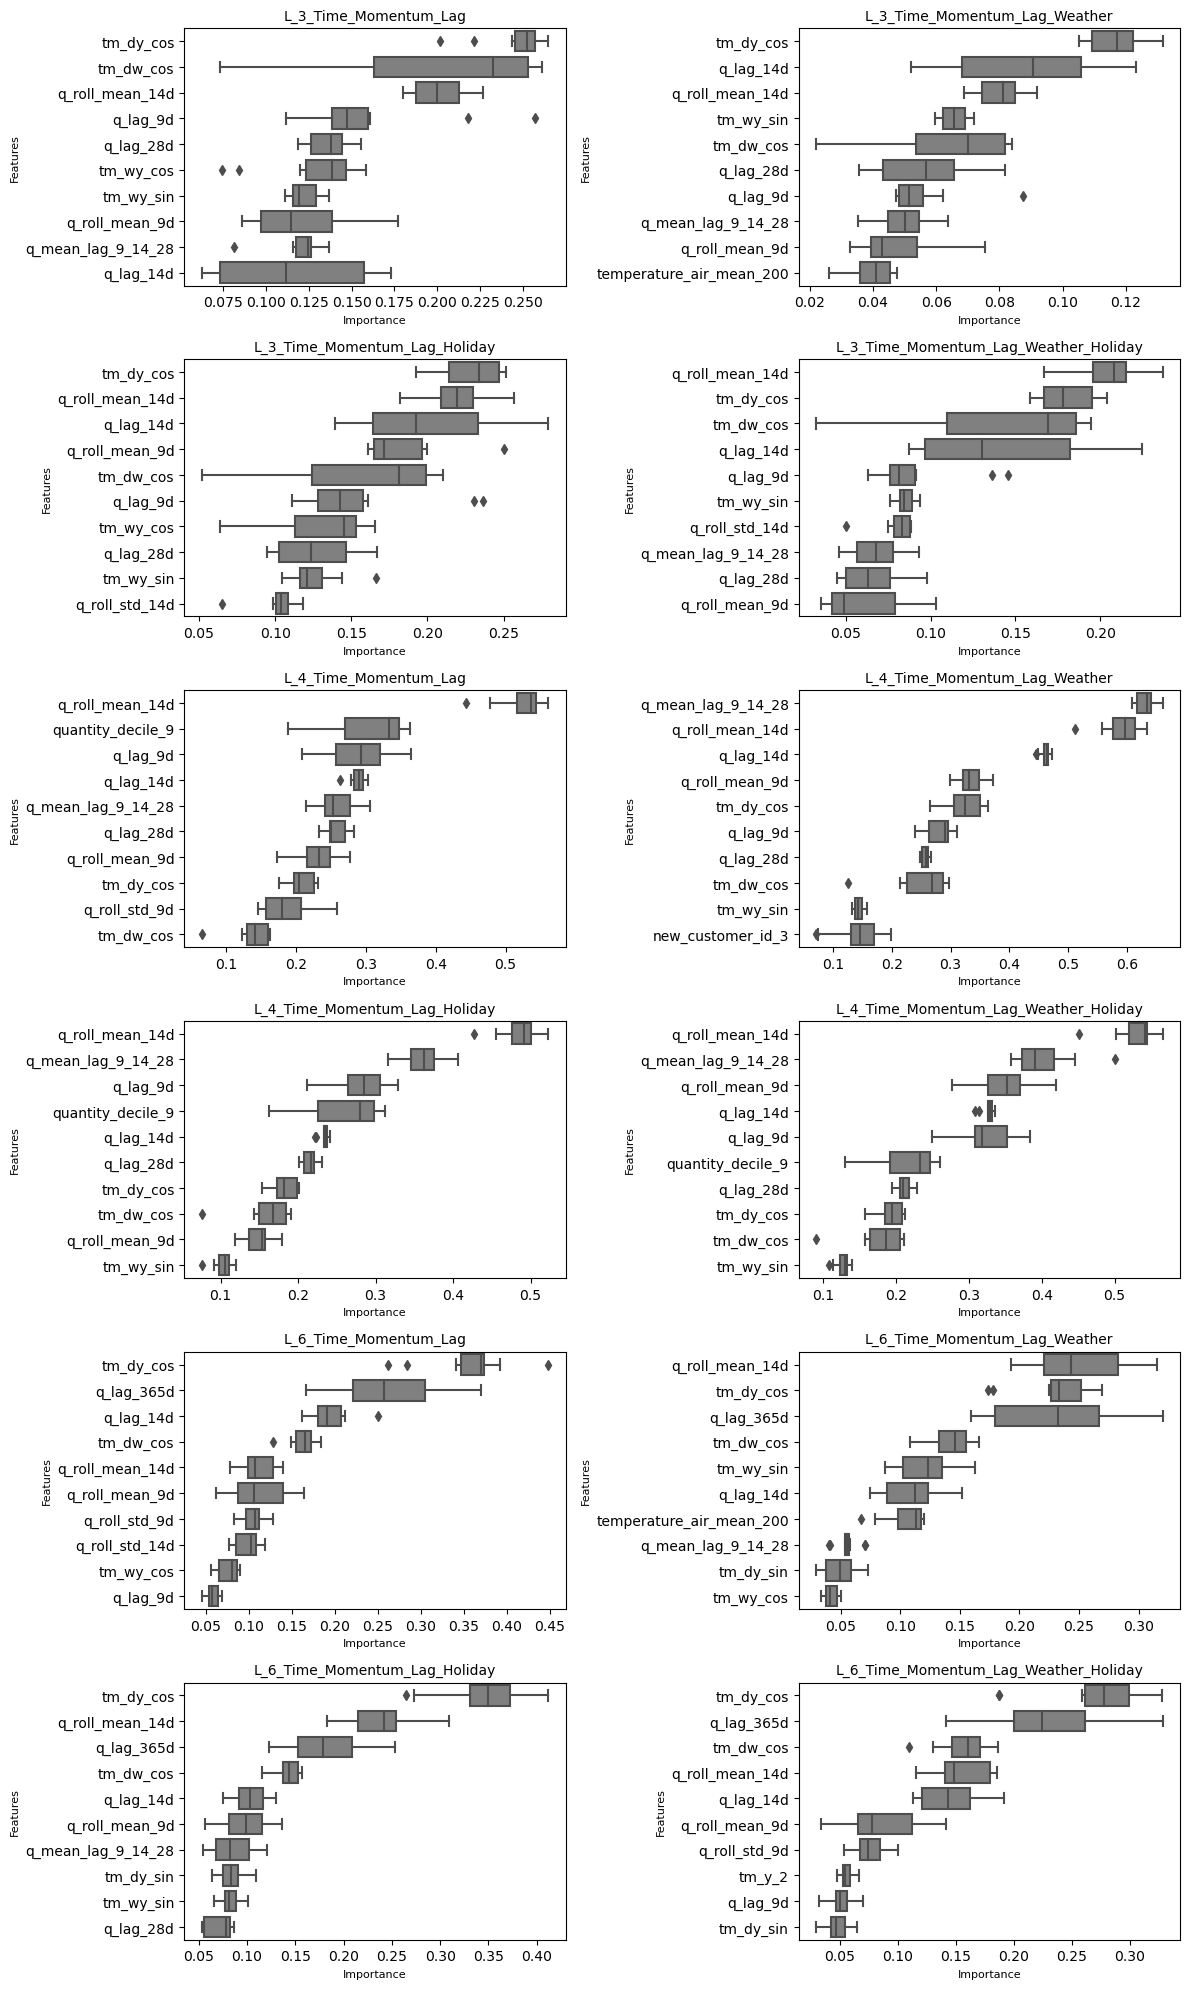

In [38]:
nr_freatures = 10
# Permutation Iportance of lgbm moddels
fig, axes = plt.subplots(6, 2, figsize=(12, 20))  # figsize in inches, changed to fit A4 dimensions
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Iterate through the feature_importance dictionary items and get the level and value
for idx, (level, value) in enumerate(lgbm_importance.items()):
    df = value["df"].sort_index()
    box_array = value["box_array"]
    columns = df.feature_names
    sns.boxplot(x="importance", y="feature_names", data=pd.DataFrame(box_array, columns=columns)\
                .melt(var_name='feature_names', value_name='importance').sort_values("importance", ascending=False),#.head(nr_freatures), 
                ax=axes[idx], 
                order=df.sort_values("importances_mean", ascending=False).head(nr_freatures).feature_names,
                color="grey")
    axes[idx].set_title(f'{level}', fontsize=10)  # adjust fontsize
    axes[idx].set_xlabel('Importance', fontsize=8)  # adjust fontsize
    axes[idx].set_ylabel('Features', fontsize=8)  # adjust fontsize
    plt.yticks(rotation=0)

# Remove the unused subplot in case you have an odd number of plots
if len(lgbm_importance) % 2 == 1:
    fig.delaxes(axes[-1])

plt.tight_layout()

# Save the figure as a PNG file
##plt.savefig('../data/figures/all_feature_importance_per_cat_lgbm.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
#I made these calc:
df['tm_dy'] = df.date.dt.dayofyear.astype(np.int8)  # Day of year +
df['tm_dm'] = df.date.dt.day.astype(np.int8)  # Day of month +
df['tm_wy'] = df.date.dt.isocalendar().week.astype(np.int8)  # week of year +
df['tm_my'] = df.date.dt.month.astype(np.int8)  # month of year +
df['tm_y'] = df.date.dt.year  # year
df['tm_y'] = (df['tm_y'] - df['tm_y'].min()).astype(np.int8)  # year - min year = number of year
df['tm_wm'] = df['tm_dm'].apply(lambda x: math.ceil(x / 7)).astype(np.int8)  # number of week in month
df['tm_dw'] = df.date.dt.dayofweek.astype(np.int8)  # number of day in week # +
df['tm_w_end'] = (df['tm_dw'] >= 5).astype(np.int8)  # indicate Weekend

# Momentum Features: Rolling averages and standard dev 9 & 14 days
product_sales['q_roll_mean_9d'] = product_sales.groupby([i])['quantity'].shift(9).rolling(9, min_periods=1)\
    .mean().reset_index().quantity.fillna(0)
product_sales['q_roll_std_9d'] = product_sales.groupby([i])['quantity'].shift(9).rolling(9, min_periods=1)\
    .std().reset_index().quantity.fillna(0)
product_sales['q_roll_mean_14d'] = product_sales.groupby([i])['quantity'].shift(9).rolling(14, min_periods=1)\
    .mean().reset_index().quantity.fillna(0)
product_sales['q_roll_std_14d'] = product_sales.groupby([i])['quantity'].shift(9).rolling(14, min_periods=1)\
    .std().reset_index().quantity.fillna(0)

# Lag Features 9 days, 14 day, 28 days and 365 days
product_sales['q_lag_9d'] = product_sales.groupby([i])['quantity'].shift(periods=9).fillna(0)
product_sales['q_lag_14d'] = product_sales.groupby([i])['quantity'].shift(periods=14).fillna(0)
product_sales['q_lag_28d'] = product_sales.groupby([i])['quantity'].shift(periods=28).fillna(0)
product_sales['q_lag_365d'] = product_sales.groupby([i])['quantity'].shift(periods=365).fillna(0)

# average of 9, 14 and 28 days
product_sales["q_mean_lag_9_14_28"] = (product_sales['q_lag_9d'] + product_sales['q_lag_14d']
                                       + product_sales['q_lag_28d'])/3

# help me rename these featues to consise intuitive names
df.feature_names.to_list()

In [17]:
import pandas as pd
import numpy as np
import math

value = lgbm_importance["L_6_Time_Momentum_Lag_Weather_Holiday"]

df = value["df"].sort_index()

# Assuming df is your DataFrame
# Rename the values in column feature_names not columns
rename_dict = {
    'tm_dm_cos': 'day_month_cos',
    'tm_dm_sin': 'day_month_sin',
    'tm_y_2': 'year_2',
    'tm_dy_sin': 'day_year_sin',
    'tm_w_end': 'is_weekend',
    'tm_dy_cos': 'day_year_cos',
    'tm_y_1': 'year_1',
    'tm_wy_sin': 'week_year_sin',
    'tm_y_0': 'year_0',
    'tm_wm_sin': 'week_month_sin',
    'tm_my_cos': 'month_year_cos',
    'tm_my_sin': 'month_year_sin',
    'tm_dw_sin': 'day_week_sin',
    'tm_dw_cos': 'day_week_cos',
    'tm_wm_cos': 'week_month_cos',
    'tm_wy_cos': 'week_year_cos',
    'q_roll_std_9d': 'quantity_rolling_std_9d',
    'q_lag_14d': 'quantity_lag_14d',
    'q_lag_28d': 'quantity_lag_28d',
    'q_mean_lag_9_14_28': 'quantity_mean_lag_9_14_28',
    'q_lag_9d': 'quantity_lag_9d',
    'q_roll_std_14d': 'quantity_rolling_std_14d',
    'q_lag_365d': 'quantity_lag_365d',
    'q_roll_mean_9d': 'quantity_rolling_mean_9d',
    'q_roll_mean_14d': 'quantity_rolling_mean_14d',
}

# Your DataFrame df now has renamed columns
df['feature_names'] = df['feature_names'].replace(rename_dict)

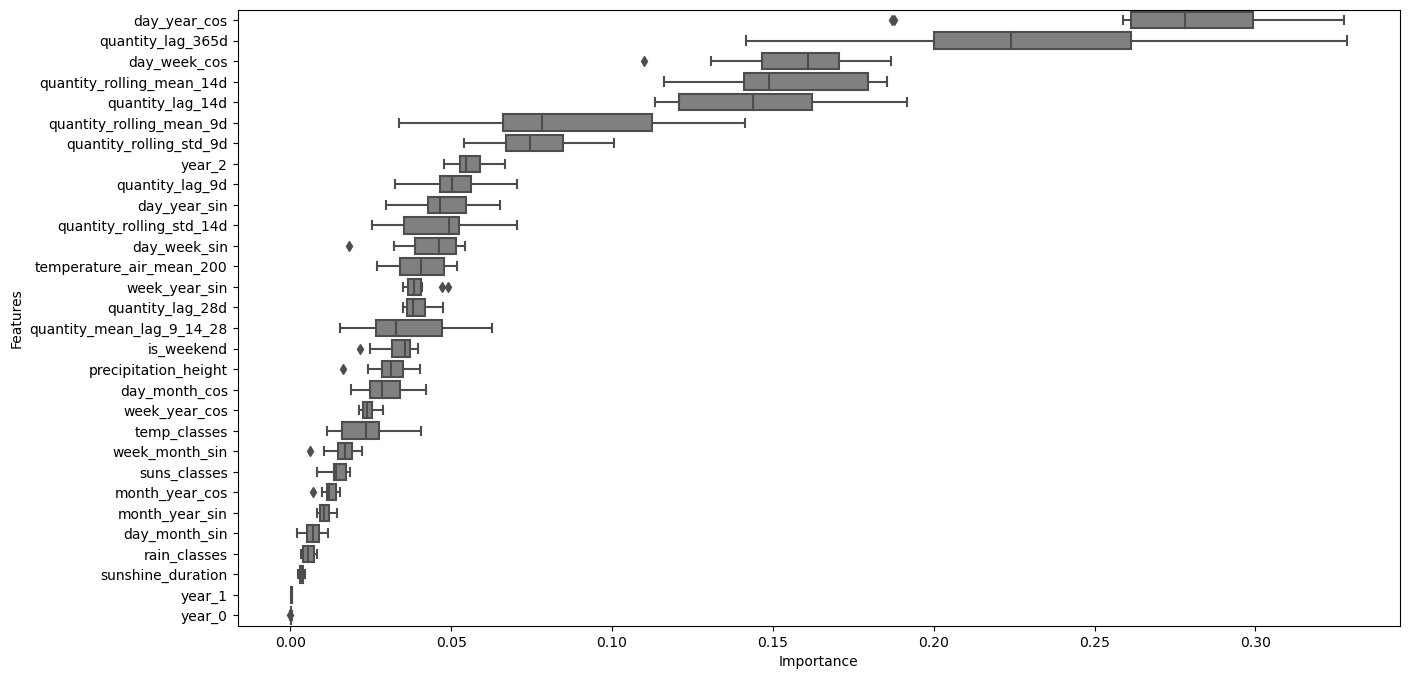

In [19]:
box_array = value["box_array"]
columns = df.feature_names

fig, axes = plt.subplots(figsize=(15, 8))  # figsize in inches, changed to fit A4 dimensions

sns.boxplot(x="importance", y="feature_names",
            data=pd.DataFrame(box_array, columns=columns).melt(var_name='feature_names', 
                                                               value_name='importance').sort_values("importance", 
                                                                                                    ascending=False),
            ax=axes,
            order=df.sort_values("importances_mean", ascending=False).head(30).feature_names,
            color="grey")

#axes.set_title('Feature Importances: L6_Weather_Holiday_lgbm', fontsize=10)  # adjust fontsize
axes.set_xlabel('Importance', fontsize=10)  # adjust fontsize
axes.set_ylabel('Features', fontsize=10)  # adjust fontsize
plt.yticks(rotation=0)

plt.savefig('../data/figures/feature_importance_L6_all_features_lgbm.png', dpi=300, bbox_inches='tight')

plt.show()

# Visualisation

Best Performing from every level

In [54]:
merged_df = back_df.append(pred_df)
merged_df

/var/folders/d1/4c4_qxp904j46j9r74vbnkd80000gn/T/ipykernel_26962/1970075970.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = back_df.append(pred_df)


,L_3_sarima,L_3_sarimax,L_3_ets,L_3_naive_drift,L_3_naive_seasonal,L_6_sarima,L_6_sarimax,L_6_ets,L_6_naive_drift,L_6_naive_seasonal,...,L_6_Time_Momentum_Lag_Weather_xgb,L_6_Time_Momentum_Lag_Holiday_xgb,L_6_Time_Momentum_Lag_Weather_Holiday_xgb,L_3_lstm,L_4_lstm,L_6_lstm,L_3_nhits,L_4_nhits,L_6_nhits,actual
date,,,,,,,,,,,,,,,,,,,,,
2022-10-13,7737.298097,7686.391311,7547.315887,8197.879488,5814.0,7491.534079,7639.707832,7312.821476,8193.832432,5814.0,...,8670.439453,6947.047852,7941.036621,8396.894531,8019.538499,10820.825195,9919.636597,8363.958084,9311.574726,8006.0
2022-10-14,7467.104306,7642.132389,7360.633403,8210.758977,5316.0,7312.758874,7440.355089,7161.535136,8202.664865,5316.0,...,7124.886719,5520.007812,8051.941406,8051.355591,8145.409599,11557.055664,15070.568481,7441.416715,9331.197466,7604.0
2022-10-15,6629.167403,6577.001856,6543.248719,8223.638465,5742.0,6776.568954,6926.946194,6440.268708,8211.497297,5742.0,...,7245.847168,6315.791992,8416.041992,7859.444092,8517.711317,12103.677734,11218.576416,7416.800714,9488.074874,7096.0
2022-10-16,8556.600472,8592.228044,13021.054359,8236.517954,11308.0,12209.207656,12310.742273,12947.406713,8220.329730,11308.0,...,10301.653320,11816.083984,10908.041992,8263.527344,8702.843378,13234.144531,15967.747314,9996.794790,13856.748700,11710.0
2022-10-17,6626.223821,6774.170298,8821.353846,8249.397442,7239.0,8334.433043,8503.070361,8586.524577,8229.162162,7239.0,...,8389.755859,7072.996094,8083.669922,8161.748535,9095.351329,13105.624023,11952.009277,8416.666483,9160.525485,6224.0
2022-10-18,6800.802436,6719.622180,8010.242270,8262.276931,8868.0,8265.078847,8423.728188,7837.461299,8237.994595,8868.0,...,7802.906738,7757.537598,8141.169434,8077.060791,9132.522869,11622.914062,12320.929565,12856.892257,9449.739733,8281.0
2022-10-19,6485.126165,6531.617372,7558.178612,8275.156419,8185.0,7994.564826,8152.146975,7396.374255,8246.827027,8185.0,...,7643.263672,7218.399414,7209.796875,8336.352295,9048.721068,11961.964844,10984.505981,10589.472835,10001.355017,6462.0
2022-10-20,6548.357913,6526.311383,7540.756742,8288.035908,5814.0,7807.962520,7972.798116,7312.365613,8255.659459,5814.0,...,7488.367188,7182.668945,7394.033691,8193.702393,8932.703731,9912.923828,12140.667114,10831.511213,11193.336964,6647.0
2022-10-21,6652.845319,6644.522747,7354.139849,8300.915396,5316.0,7708.226850,7845.535543,7161.083831,8264.491892,5316.0,...,7077.358887,7788.453613,7925.740234,8404.859863,8990.825789,8902.305664,10227.789062,10868.648368,10029.454123,6137.0


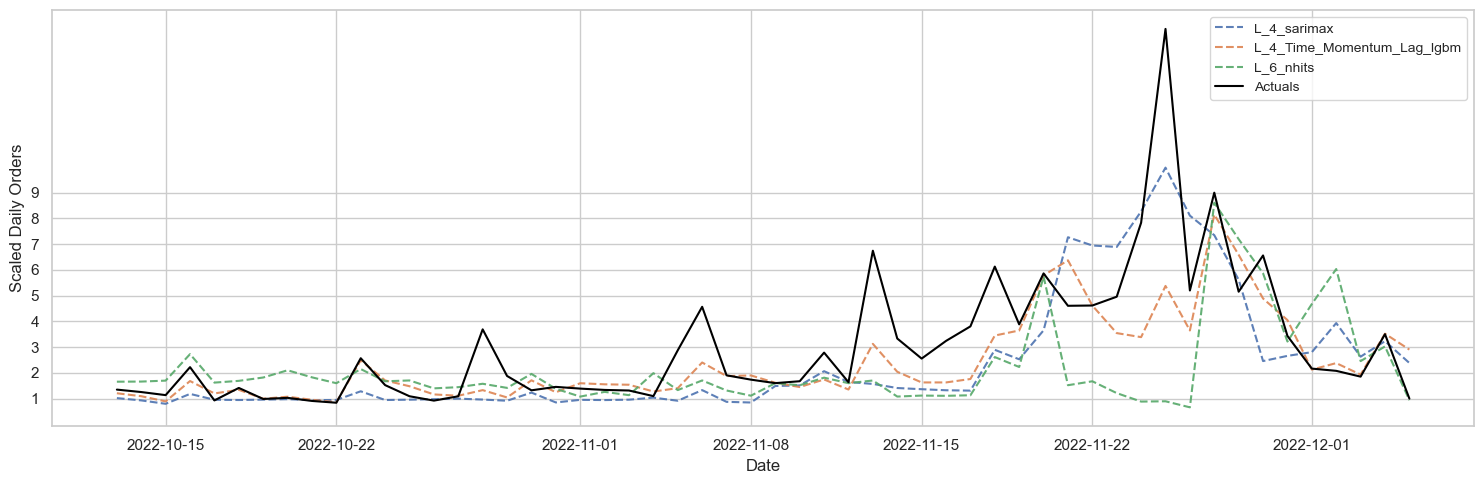

In [55]:
best_ts_models = pd.Series(ts_error.sort_values("pred_rmse")[0:1].index.unique())
best_lgbm_models = pd.Series(lgbm_error.sort_values("pred_rmse")[0:1].category.unique())
#best_xgb_models = pd.Series(xgb_error[0:1].category.unique())
#best_lstm_models = pd.Series(lstm_error[0:1].index.unique())
best_nhits_models = pd.Series(nhits_error.sort_values("pred_rmse")[0:1].index.unique())
#best_ens_models = pd.Series(ensemble_metrics_df[2:3].category.unique())  # best 2!

# add "_lgbm" and "_xgb" to best_lgbm_models and best_xgb_models
best_lgbm_models = best_lgbm_models.map(lambda x: f'{x}_lgbm')
#best_xgb_models = best_xgb_models.map(lambda x: f'{x}_xgb')

list_of_best_models = pd.concat([best_ts_models, best_lgbm_models, best_nhits_models])

# Set the style for the plot
sns.set(style="whitegrid", font_scale=1)

# Create the time series plot
plt.figure(figsize=(15, 5))

# Plot each model
for model in list_of_best_models:
    plt.plot(merged_df.index, merged_df[model], label=model, linestyle="--", alpha=0.9)

# The rest of your code...
# Plot the Actuals with a thicker, solid line and a distinct color
plt.plot(merged_df.index, merged_df["actual"], label="Actuals", color="black", linewidth=1.5)

# Get the number of y-ticks
n = len(plt.gca().get_yticks())

# Set new y-tick labels
plt.yticks(np.linspace(min(pred_df["actual"]), max(pred_df["actual"]), n), range(1, n+1))

# Customize the plot
plt.xlabel("Date")
plt.ylabel("Scaled Daily Orders")
plt.legend(loc="best", fontsize=10)
# Hide y-axis values
#plt.yticks([])

plt.tight_layout()
# save
#plt.savefig('../data/figures/forecast_comparison_best_category.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [ ]:
# Set the style for the plot
sns.set(style="whitegrid", font_scale=1)

# Create the time series plot
plt.figure(figsize=(15, 5))

# Plot each model
for model in list_of_best_models:
    
    # add if statement. If model in pred_ens_df plot else plot with pred_df
    if model in pred_ens_df.columns:
        plt.plot(back_ens_df.index, back_ens_df[model], label=model, linestyle="--", alpha=0.9)
        
    else:
        plt.plot(back_df.index, back_df[model], label=model, linestyle="--", alpha=0.9)

# The rest of your code...
# Plot the Actuals with a thicker, solid line and a distinct color
plt.plot(back_df.index, back_df["actual"], label="Actuals", color="black", linewidth=1.5)

# Get the number of y-ticks
n = len(plt.gca().get_yticks())

# Set new y-tick labels
plt.yticks(np.linspace(min(pred_df["actual"]), max(pred_df["actual"]), n), range(1, n+1))

# Customize the plot
plt.xlabel("Date")
plt.ylabel("Scaled Daily Orders")
plt.legend(loc="best", fontsize=10)

# Hide y-axis values
#plt.yticks([])

plt.tight_layout()
# save
plt.savefig('../data/figures/backtest_comparison_best_category.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()